# Lecture 24 (5/20/2022)

**Announcements**


*Last time we covered:*
- Evaluating $k$-means (and other clustering solutions)

**Today's agenda:**
- Clustering with Gaussian Mixture Models


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Review: challenges with $k$-means

In Wednesday's lecture, we discussed a shortcoming of $k$-means clustering: the algorithm assumes that **all the clusters are the same variance**.

In some cases, when we have data that is very *clearly clustered* but unequal variance, the algorithm fails to cluster the data in the way we would want.

To illustrate this, here's a set of data we might want to cluster. This has a pretty intuitive clustering solution:

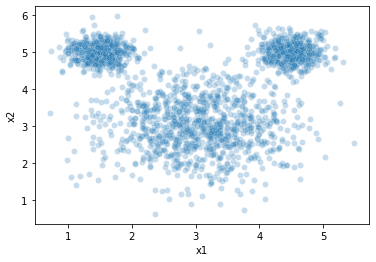

In [2]:
from sklearn.datasets import make_blobs

mouse_vals, mouse_clusters = make_blobs(n_samples = [1000, 500, 500], # how many samples to generate 
                                          n_features = 2, # number of features
                                          centers = [(3, 3), (1.5, 5), (4.5, 5)], # how many "blobs"
                                          cluster_std = [0.75, 0.25, 0.25], # SD of the blobs (can be a list)
                                          random_state = 1
                                         )

sns.scatterplot(x = mouse_vals[:, 0], 
                y = mouse_vals[:, 1], 
#                 hue = mouse_clusters, # toggle comment this
                alpha = 0.25
               )
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

However, when we estimate clusters in this data using $k$-means clustering, we get a very unintuitive solution:

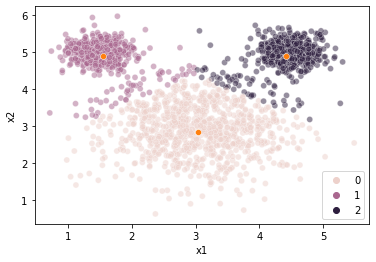

In [3]:
from sklearn.cluster import KMeans

kmouse = KMeans(n_clusters = 3, random_state = 1).fit(X = mouse_vals)

sns.scatterplot(x = mouse_vals[:, 0], 
                y = mouse_vals[:, 1], 
                hue = kmouse.labels_,
                alpha = 0.5
               )
# Show cluster centers
sns.scatterplot(x = kmouse.cluster_centers_[:, 0], 
                y = kmouse.cluster_centers_[:, 1]
               )
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

**Our $k$-means clustering is finding 3 cluster centers and then assigning points to their closest center without any ability to accommodate the fact that the clusters are of different sizes (size == variance here, not number of elements).**

![kmouse_clusters](img/kmouse_clusters.png)

***What can we do about this? How do we revise our clustering solution to allow for clusters that vary in size?***

...

***

# Gaussian Mixture Models: generalizing $k$-means

One way we can think about $k$-means clustering is that it tries to find a set of cluster *means* (as the name implies) that minimize the inertia of the data points around their closest mean. 

What Gaussian Mixture Models do is solve the same problem but with two additional improvements:
- We also identify an optimal *variance* for each cluster (same dimensions as the data: a covariance matrix)
- We identify a *weight* for each cluster that reflects the different number of data points assigned to each one

These are some big improvements! *Is it magic???* No, it's Gaussians. 

This amounts to finding a set of *multi-variate Gaussians* whose individual means and variances best capture the data (plus their corresponding weights). 

Critically, this allows our clusters to have different sizes and shapes, which *loosens* the constraint implied by $k$-means that the clusters only vary in their means. 

![em](img/em.gif)

(Source: [wikipedia](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm))

In the example above, we use this approach to identify two clusters of types of Old Faithful eruptions, using the *Duration* and *Delay* of each observed eruption. Note that the end state of the GIF is essentially two different Gaussians that may have different means and covariance values, and different numbers of points in each cluster.

**Overview**

Gaussian Mixture Models estimate three *parameters* in our data:
1. A vector of *means* $\mu$ with an individual mean $\mu_j$ for each of our $k$ clusters
2. A vector of *covariances* $\Sigma$ with $\Sigma_j$ for each of our $k$ clusters
3. A vector of *weights* $w$ that determines the relative densities of our clusters. Note these weights sum to 1: $\sum_{j=1}^{k} w_j = 1$

Using these parameters, often referred to as $\theta = \{\mu, \Sigma, w\}$, we can estimate, for all of our data points, the probability that they were sampled from their respective cluster. Note: if we compare this to $k$-means, which just assigns each point to a cluster, $k$-means and GMMs are similar to *hard classification* and *soft classification* applied to clustering.

In this formulation, we assign the probability of our data $X$ given the parameters $\theta$ above to be:
$$p(X | \theta) = \sum_{j=1}^{k} w_j \ \mathcal{N}(X | \mu_j, \Sigma_j)$$

Here, $\mathcal{N}(X | \mu_j, \Sigma_j)$ is just the probability of our data points under a normal (multi-variate Gaussian) distribution with mean $\mu_j$ and covariance $\Sigma_j$.

The challenge for our model is to find the parameter values $\theta = \{\mu, \Sigma, w\}$ that maximizes $p(X | \theta)$:

$$\hat{\theta} = arg max_{\theta} p(X | \theta)$$

It turns out, there's a (relatively) straightforward process for doing this.

## Estimating GMMs

There's a really excellent tutorial [here](https://towardsdatascience.com/gaussian-mixture-models-and-expectation-maximization-a-full-explanation-50fa94111ddd) that walks through how this works with the `iris` dataset (the first part anyway; later on things get a little more complicated). Another tutorial [here](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95) illustrates the math in fine detail if you want to understand this on a more technical level. 

The process of estimating this model follows two steps, very similar to $k$-means clustering!

**Initialization**

Like $k$-means, we start by *initializing our clusters*. With $k$-means all we needed was to guess our cluster centers. Now, we need initial estimates for all the parameters above: $\mu$, $\Sigma$, and $w$. 

- $w$: For our weights, we can assume to start that each cluster has an equal number of data points: $w_j = 1/k$
- $\mu$: in theory, we can initialize our $\mu$ values to be randomly sampled points like we did with $k$-means. However, the more popular approach here is to actually run $k$-means and use the centers that it estimates!
- $\Sigma$: our covariance matrix can be initialized to something generic (identity matrix, 1s, etc.)

**Step 1**

Now, the first step of the algorithm is to figure out the *probability that each data point was sampled from each of the potential clusters* with the cluster parameters initialized above.

Essentially, we make a table like the one below for each point in $X$. This table assumes that $X$ is 2-dimensional as in our mouse example above, and assumes there are 3 clusters:


| $x$ | $p(j=1)$ | $p(j=2)$ | $p(j=3)$ | 
| :---: | :---: | :---: | :---: |
| (1, 3) |  |  | | |
| (2, 5) |  |  | | |
| ... |  |  | | |


With multi-variate Gaussians, the probability that a point was sampled from a particular distribution is pretty straightforward: we can use the probability density function for the Gaussian with the current parameter estimates $\mu_j$ and $\Sigma_j$.
- Here, we also scale the probabilities by the weights for each cluster and divide by the probabilities assigned to the other clusters for each point. 
- So each row in the table above would have $x_1$ and $x_2$ values for a given point, plus three probabilities that sum to 1 indicating the probability of that point belonging to each cluster $j$. 

For cluster 1, we would set the probability that $x_i$ is in cluster 1 to be:

$$p(x_i = \text{cluster 1} | \ \theta) = \dfrac{w_1 \ \mathcal{N}(x_i | \mu_1, \Sigma_1)}{\sum_{j=1}^{k} w_j \ \mathcal{N}(x_i | \mu_j, \Sigma_j)} $$

Note this step echoes the *assignment* step of $k$-means, except we're calculating a *probability* for each point belonging in each cluster instead of simply assigning each point to a cluster.

**Step 2**

Next, we figure out the *best parameter estimates* for each cluster **based on the probabilities assigned to each data point in Step 1**. This echoes the step in $k$-means where we re-evaluated each cluster center. However, now things are more complicated because we need to revise all the cluster parameters above.
- $w_j$: We start by adding up the probability of each point belonging to cluster $j$ from Step 1. This tells us how many points we *expect* to have in that cluster. Then, we set each weight $w_j$ to just be the number of points estimated for that cluster divided by the total number of data points $N$. For example, our weight for cluster 1, $w_1$, would be set to:
$$w_1 := \dfrac{\sum_{i=1}^{N} p(j=1)_i}{N}$$
- $\mu_j$: Our $\mu_j$, the estimated mean of each cluster, will be the average of all our data points weighted by the probability of each value belonging to cluster $j$. For example:
$$\mu_1 := \dfrac{\sum_{i=1}^{N} x_n \ p(j=1)_i}{\sum_{i=1}^{N} p(j=1)_i}$$
- $\Sigma_j$: Our $\Sigma_j$, similar to the above, will be the covariance of all our datapoints $(x_1, x_2)$, weighted by the probability of each point belonging to our cluster $j$. If you're familiar with the notation for expressing covariance below, it looks like this:
$$\Sigma_1 := \dfrac{\sum_{i=1}^{N} p(j=1)_i \ (x_i - \mu_1)(x_i - \mu_1)^T}{\sum_{i=1}^{N} p(j=1)_i}$$

The formal steps for these parameter updates isn't super important (but is helpful if this is familiar notation!). The key take-away is the *operation* being done.

**Step 3** 

Repeat Step 1 and Step 2 until convergence. Convergence occurs when we've more or less maximized our *log likelihood*, the $log \ p(X | \theta)$ using the equation for $p(X | \theta)$ above.



## Aside: Expectation Maximization

If the above seemed like an especially tedious trip into the depths of model estimation, there's a reason we did this!

Steps 1 and 2 in the model estimation process above are examples of a *more general process called Expectation Maximization*.

Using EM to estimate a model's parameters involves breaking down the process into two steps:

1. The **"E-Step"**: what is the (expected) likelihood of the data $X$ given the current estimates for the parameters $\theta$ (Step 1 above)?

2. The **"M-Step"**: what are the parameter estimates $\theta$ that will maximize the likelihoods in the previous *E-Step* (Step 2 above)?

In fact, the process for simple $k$-means clustering that we discussed on Wednesday is *also* a simplified example of the EM process:
- E-Step: assign data points to the nearest cluster
- M-Step: estimate the new cluster centers given the data point assignments

Expectation Maximization is a way to estimate model parameters when those parameters depend on *latent variables*, in this case our cluster assignments. We don't need to get into the formal details of EM more generally, but this way you're familiar with the underlying idea behind the algorithms for $k$-means and GMMs above. 

Now, let's jump into the actual coding!

## Gaussian Mixture Models in sklearn

The `GaussianMixture` class documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

There's a nice overview of how they work in sklearn [here](https://scikit-learn.org/stable/modules/mixture.html).


In [4]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 3, random_state = 1)

gm.fit(X = mouse_vals)
gm

GaussianMixture(n_components=3, random_state=1)

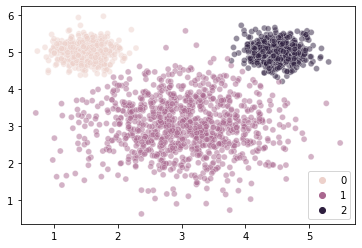

In [5]:
labels = gm.fit_predict(X = mouse_vals)
labels

sns.scatterplot(
    x = mouse_vals[:, 0], 
    y = mouse_vals[:, 1], 
    hue = labels,
    alpha = 0.5
)
plt.show()

# WOW!!

*What information did we fit?*

In [6]:
gm.converged_ # Did it work?
gm.n_iter_ # How many iterations?

5

The `n_iter_` attribute above tells us how many times the Expectation Maximization algorithm ran to estimate the parameters.

*What about the parameter values themselves?*

In [7]:
gm.means_ # Original: [(3, 3), (1.5, 5), (4.5, 5)]

array([[1.49291625, 4.99385141],
       [3.03299495, 3.01461154],
       [4.50139164, 4.99700108]])

**Our recovered means are very close to the ones that generated the data.**

How do our recovered standard deviations compare?

In [8]:
gm.covariances_ # Covariance matrix estimate (x1 and x2) for each cluster

gm.covariances_[0]
np.sqrt(gm.covariances_[0, 0, 0]) # compare to 0.25 for cluster 0
np.sqrt(gm.covariances_[0, 1, 1]) # compare to 0.25 for cluster 0

gm.covariances_[1]
np.sqrt(gm.covariances_[1, 0, 0]) # compare to 0.25 for cluster 1
np.sqrt(gm.covariances_[1, 1, 1]) # compare to 0.25 for cluster 1

gm.covariances_[2]
np.sqrt(gm.covariances_[2, 0, 0]) # compare to 0.75 for cluster 2
np.sqrt(gm.covariances_[2, 1, 1]) # compare to 0.75 for cluster 2

0.25725040914132336

Pretty good! We did generate this data using Gaussian mixtures, but even so...

Finally, we can see what *weights* it estimated for our data, i.e., the relative density of points in each cluster:

In [9]:
gm.weights_ # Original values: 100, 100, 300

array([0.25146957, 0.49802568, 0.25050475])

Woo hoo!

## Evaluating Gaussian Mixture Models

One of the advantages of the Expectation Maximization algorithm used to fit GMMs is that we have a *likelihood value* that tells us how well our data fits the model with the specified parameters (specifically, the probability of our data $X$ given the model parameter estimates $\theta$, $p(X | \theta)$). 

We can use this as the basis for evaluating our model or comparing it to other possible models (e.g., ones with more or fewer clusters).

Scores like ***[AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)*** (Akaike Information Criterion, see also [here](https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced)) or ***[BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)*** (Bayesian Information Criterion), both exported by the `GaussianMixture` class, are based on the likelihood of our model fit. They tell you how well your model accounts for the data, while penalizing models that have *more* parameters.

We can use these values to evaluate our model or (more often) compare it to other models.


In [10]:
gm.score(X = mouse_vals) # this is the average per-sample log likelihood of our data
gm.aic(X = mouse_vals) # AIC
gm.bic(X = mouse_vals) # BIC

8853.800356844406

Let's see how this compares to if we fit a model above with only *two* clusters:

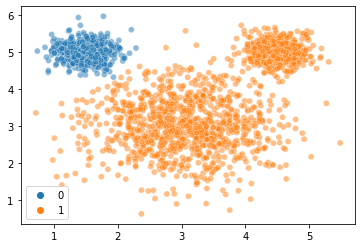

In [11]:
gm2 = GaussianMixture(n_components = 2, random_state = 1)
labels2 = gm2.fit_predict(X = mouse_vals)
labels2

sns.scatterplot(
    x = mouse_vals[:, 0], 
    y = mouse_vals[:, 1], 
    hue = labels2,
    alpha = 0.5
)
plt.show()

Yikes! How does this compare to the 3 cluster version?

In [12]:
gm2.aic(X = mouse_vals) # lower is better, so this is worse than the 3 cluster one above!
gm2.bic(X = mouse_vals) # same story here

10311.399648442439

## Failure Modes

Because of the additional complexity involved in estimating Gaussian mixture models, things can sometimes go awry, e.g., when there are few data points in a given cluster. We're not going to dive into this, but it's worth being aware of.

Some of these problems can be avoided by starting out with pretty good guesses about the Gaussian means. 

How do we make good starting guesses? 

$k$-means clustering! 

The sklearn `GaussianMixture` class has an `init_params` argument specifying how the initial parameter values should be estimated.
- The default value for this is "kmeans", but you can also supply "kmeans++" or two versions of random selection.


# Practice

If we get through all the above with time left over, you can practice fitting a GMM yourself! 

Read in the `iris` dataset and try using a Gaussian Mixture Model to cluster the iris species (you can use any 1, 2, or all 4 features).


In [13]:
### YOUR CODE HERE

iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
